# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-34-47/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4876 | MulticlassF1Score=0.1711
Batch-30 : CrossEntropyLoss=2.4909 | MulticlassF1Score=0.2100
Batch-45 : CrossEntropyLoss=2.4715 | MulticlassF1Score=0.2250
Batch-60 : CrossEntropyLoss=2.5035 | MulticlassF1Score=0.2321
Batch-75 : CrossEntropyLoss=2.4703 | MulticlassF1Score=0.2376
Batch-90 : CrossEntropyLoss=2.4967 | MulticlassF1Score=0.2413
Batch-105: CrossEntropyLoss=2.4936 | MulticlassF1Score=0.2445
Batch-120: CrossEntropyLoss=2.4410 | MulticlassF1Score=0.2557
Batch-135: CrossEntropyLoss=2.4361 | MulticlassF1Score=0.2697
Batch-150: CrossEntropyLoss=2.4371 | MulticlassF1Score=0.2832
Batch-165: CrossEntropyLoss=2.3903 | MulticlassF1Score=0.3045
Batch-180: CrossEntropyLoss=2.3686 | MulticlassF1Score=0.3273
Batch-195: CrossEntropyLoss=2.3671 | MulticlassF1Score=0.3479
Batch-210: CrossEntropyLoss=2.3800 | MulticlassF1Score=0.3657
Batch-225: CrossEntropyLoss=2.3648 | MulticlassF1Score=0.3813
Batch-226: CrossEntropyLoss=2.3687 | MulticlassF1Score=0.3821

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3694 | MulticlassF1Score=0.6032
Batch-30 : CrossEntropyLoss=2.3597 | MulticlassF1Score=0.5975
Batch-45 : CrossEntropyLoss=2.3778 | MulticlassF1Score=0.5964
Batch-60 : CrossEntropyLoss=2.3636 | MulticlassF1Score=0.5945
Batch-63 : CrossEntropyLoss=2.3782 | MulticlassF1Score=0.5957

Training   : Mean CrossEntropyLoss = 2.4494 | Mean MulticlassF1Score = 0.2637
Validation : Mean CrossEntropyLoss = 2.3732 | Mean MulticlassF1Score = 0.6007

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3650 | MulticlassF1Score=0.6079
Batch-30 : CrossEntropyLoss=2.3802 | MulticlassF1Score=0.5990
Batch-45 : CrossEntropyLoss=2.3760 | MulticlassF1Score=0.5990
Batch-60 : CrossEntropyLoss=2.3421 | MulticlassF1Score=0.6178
Batch-75 : CrossEntropyLoss=2.3252 | MulticlassF1Score=0.6309
Batch-90 : CrossEntropyLoss=2.3468 | MulticlassF1Score=0.6422
Batch-105: CrossEntropyLoss=2.3273 | MulticlassF1Score=0.6531
Batch-120: CrossEntropyLoss=2.3302 | MulticlassF1Score=0.6606
Batch-135: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.6675
Batch-150: CrossEntropyLoss=2.3235 | MulticlassF1Score=0.6726
Batch-165: CrossEntropyLoss=2.3529 | MulticlassF1Score=0.6757
Batch-180: CrossEntropyLoss=2.3379 | MulticlassF1Score=0.6792
Batch-195: CrossEntropyLoss=2.3309 | MulticlassF1Score=0.6827
Batch-210: CrossEntropyLoss=2.3471 | MulticlassF1Score=0.6854
Batch-225: CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6878
Batch-226: CrossEntropyLoss=2.3237 | MulticlassF1Score=0.6879

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3263 | MulticlassF1Score=0.7218
Batch-30 : CrossEntropyLoss=2.3364 | MulticlassF1Score=0.7274
Batch-45 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.7262
Batch-60 : CrossEntropyLoss=2.3346 | MulticlassF1Score=0.7240
Batch-63 : CrossEntropyLoss=2.3271 | MulticlassF1Score=0.7238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3454 | Mean MulticlassF1Score = 0.6480
Validation : Mean CrossEntropyLoss = 2.3334 | Mean MulticlassF1Score = 0.7223

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3289 | MulticlassF1Score=0.7273
Batch-30 : CrossEntropyLoss=2.3295 | MulticlassF1Score=0.7263
Batch-45 : CrossEntropyLoss=2.3331 | MulticlassF1Score=0.7264
Batch-60 : CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7247
Batch-75 : CrossEntropyLoss=2.3240 | MulticlassF1Score=0.7271
Batch-90 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7345
Batch-105: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7418
Batch-120: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7468
Batch-135: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7511
Batch-150: CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7559
Batch-165: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7596
Batch-180: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7622
Batch-195: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7642
Batch-210: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7668
Batch-225: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7686
Batch-226: CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7978
Batch-30 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7966
Batch-45 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7937
Batch-60 : CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7919
Batch-63 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7923

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3200 | Mean MulticlassF1Score = 0.7439
Validation : Mean CrossEntropyLoss = 2.3122 | Mean MulticlassF1Score = 0.7951

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7945
Batch-30 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.7941
Batch-45 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7960
Batch-60 : CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7938
Batch-75 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7954
Batch-90 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7982
Batch-105: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7997
Batch-120: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8012
Batch-135: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8014
Batch-150: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8026
Batch-165: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8048
Batch-180: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8067
Batch-195: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8080
Batch-210: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8093
Batch-225: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8106
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8107

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8293
Batch-30 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8283
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8267
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8261
Batch-63 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3067 | Mean MulticlassF1Score = 0.8005
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8287

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8268
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8281
Batch-45 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8297
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8276
Batch-75 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8285
Batch-90 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8284
Batch-105: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8289
Batch-120: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8289
Batch-135: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8294
Batch-150: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8299
Batch-165: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8302
Batch-180: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8299
Batch-195: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8300
Batch-210: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8305
Batch-225: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8303
Batch-226: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8303

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8280
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8288
Batch-63 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8292
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8296

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8394
Batch-30 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8330
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8338
Batch-60 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8370
Batch-75 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8389
Batch-90 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8401
Batch-105: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8414
Batch-120: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8417
Batch-135: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8425
Batch-150: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8432
Batch-165: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8437
Batch-180: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8442
Batch-195: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8444
Batch-210: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8447
Batch-225: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8448
Batch-226: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8394
Batch-30 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8424
Batch-45 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8426
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8456
Batch-63 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8455

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8407
Validation : Mean CrossEntropyLoss = 2.2956 | Mean MulticlassF1Score = 0.8423

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8511
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8550
Batch-45 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8542
Batch-60 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8547
Batch-75 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8554
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8560
Batch-105: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8563
Batch-120: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8568
Batch-135: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8565
Batch-150: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8568
Batch-165: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8575
Batch-180: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8586
Batch-195: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8602
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8619
Batch-225: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8632
Batch-226: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8808
Batch-30 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8800
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8792
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8783
Batch-63 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8784

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2904 | Mean MulticlassF1Score = 0.8562
Validation : Mean CrossEntropyLoss = 2.2859 | Mean MulticlassF1Score = 0.8805

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8844
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8883
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8872
Batch-75 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8878
Batch-90 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8880
Batch-105: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8879
Batch-120: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8873
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8867
Batch-150: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8868
Batch-165: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8870
Batch-180: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8868
Batch-195: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8872
Batch-210: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8871
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8871
Batch-226: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8871

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8791
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8784
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8795
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8811
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8814

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8864
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8793

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8928
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8924
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8924
Batch-75 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8921
Batch-90 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8924
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8918
Batch-135: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8915
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8911
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8909
Batch-180: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8906
Batch-195: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8903
Batch-210: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8904
Batch-225: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8906
Batch-226: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8907

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8867
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8839
Batch-60 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8839
Batch-63 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8836

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8914
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8859

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8955
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8906
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8922
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8933
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8927
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8936
Batch-105: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8938
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8939
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8938
Batch-150: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8931
Batch-165: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8933
Batch-180: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8934
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8932
Batch-210: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8933
Batch-225: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8854
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8848
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8842
Batch-63 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8842

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8934
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8849

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8967
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8957
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8942
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8947
Batch-90 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8945
Batch-105: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8931
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8938
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8940
Batch-150: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8942
Batch-165: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8939
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8942
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8946
Batch-210: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8944
Batch-225: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8944
Batch-226: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8943

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8835
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8850
Batch-63 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8843

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8946
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8837

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8964
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8969
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8965
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8955
Batch-90 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8944
Batch-105: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8958
Batch-120: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8956
Batch-135: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8950
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8948
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8955
Batch-195: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8955
Batch-210: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8958
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8960
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8961

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8889
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8848
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8855
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8865

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8958
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8975
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8986
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8974
Batch-75 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8973
Batch-105: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8972
Batch-120: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8972
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8974
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8973
Batch-165: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8976
Batch-180: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8977
Batch-195: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8979
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8979
Batch-225: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8980
Batch-226: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8979

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8893
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8887
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8884

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8973
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8887

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9057
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9105
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9143
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9164
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9176
Batch-105: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9178
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9191
Batch-135: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9193
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9198
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9210
Batch-180: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9216
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9215
Batch-225: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9219
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9219

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9115
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9137
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9130

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9161
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9137

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9272
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9269
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9272
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9278
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9277
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9283
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9284
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9285
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9287
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9289
Batch-225: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9288
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9288

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9171
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9157
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9162

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9276
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9174

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9331
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9305
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9299
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9302
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9306
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9308
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9312
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9308
Batch-165: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9309
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9308
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9309
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9310
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9312
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9312

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9166
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9173
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9171

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9176

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9354
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9346
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9335
Batch-90 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9333
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9333
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9332
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9332
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9333
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9336
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9338
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9336
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9334
Batch-226: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9333

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9181
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9179
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9183

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9335
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9195

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9354
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9352
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9355
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9351
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9348
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9349
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9352
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9354
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9354

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9196
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9195

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9201

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9368
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9362
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9362
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9366
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9365
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9366
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9367
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9364
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9185
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9370
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9196

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9354
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9360
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9359
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9363
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9368
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9368
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9371
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9144
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9199
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9184

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9395
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9386
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9382
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9380
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384
Batch-165: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9381
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9378
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9377
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9206
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9198

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9393
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9212

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9384
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9386
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9380
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9380
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9380

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9385
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9220

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9402
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9392
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9392
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9390
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9390

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9190
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9180

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9345
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9392
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9394
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9159
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9196

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9406
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9250

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9435
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9439
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9435
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9236

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9251

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9242

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9240

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9455
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9452

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9258

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9455
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9459
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9269

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9271

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9296
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9289

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9551
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9579
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9594
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9609
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9619
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9623
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9634
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9594
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9452

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9468

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9464

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9672
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9466

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9466

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9708
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9462

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2508 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9465

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9491

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9737
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9726
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9715
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9457
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9734
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9477

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9708
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9706
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9472
Patience = 2/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9476

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9722
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9724
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9723
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9721
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2510 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9718
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9522
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9513

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9752
Batch-30 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9729
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2510 | MulticlassF1Score=0.9729
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9721
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9719
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9724
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9464

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9730
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9513
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9498
Patience = 3/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9716
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9715
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9720
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9722
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9719
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9480

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9495
Patience = 4/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2560
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9718
Best MulticlassF1Score validation : 0.9478
Training duration                 : 2.7155 minutes.
Training date                     : 2022-10-19 14:06:30.384524+08:00


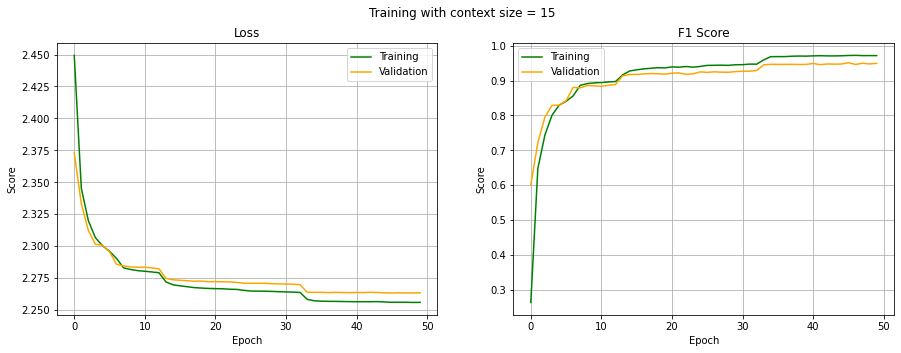

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9502, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9502, device='cuda:0'))

## Heatmap

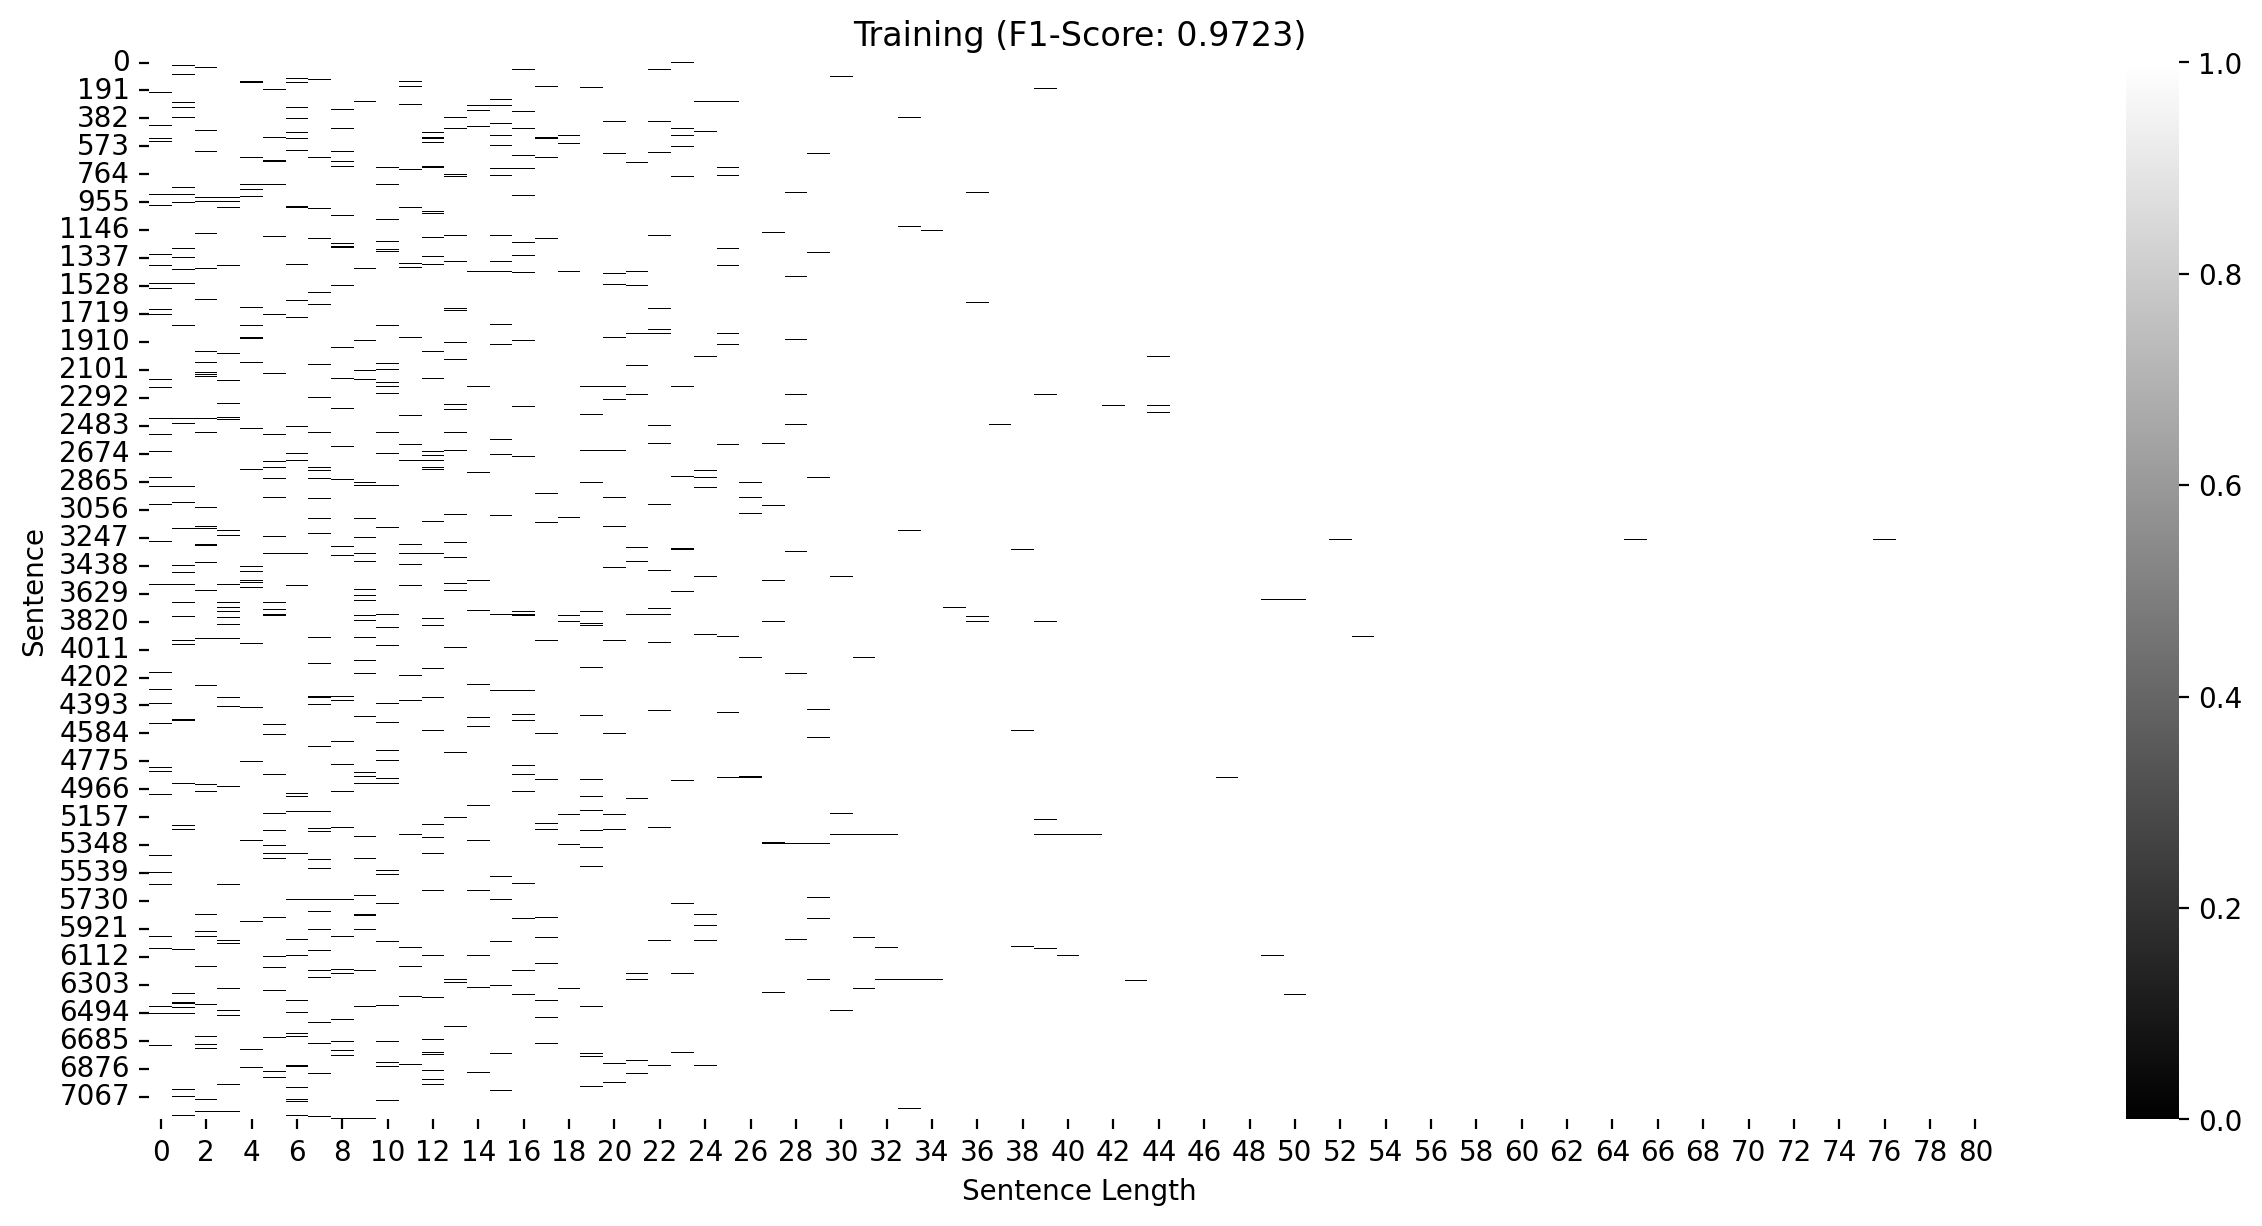

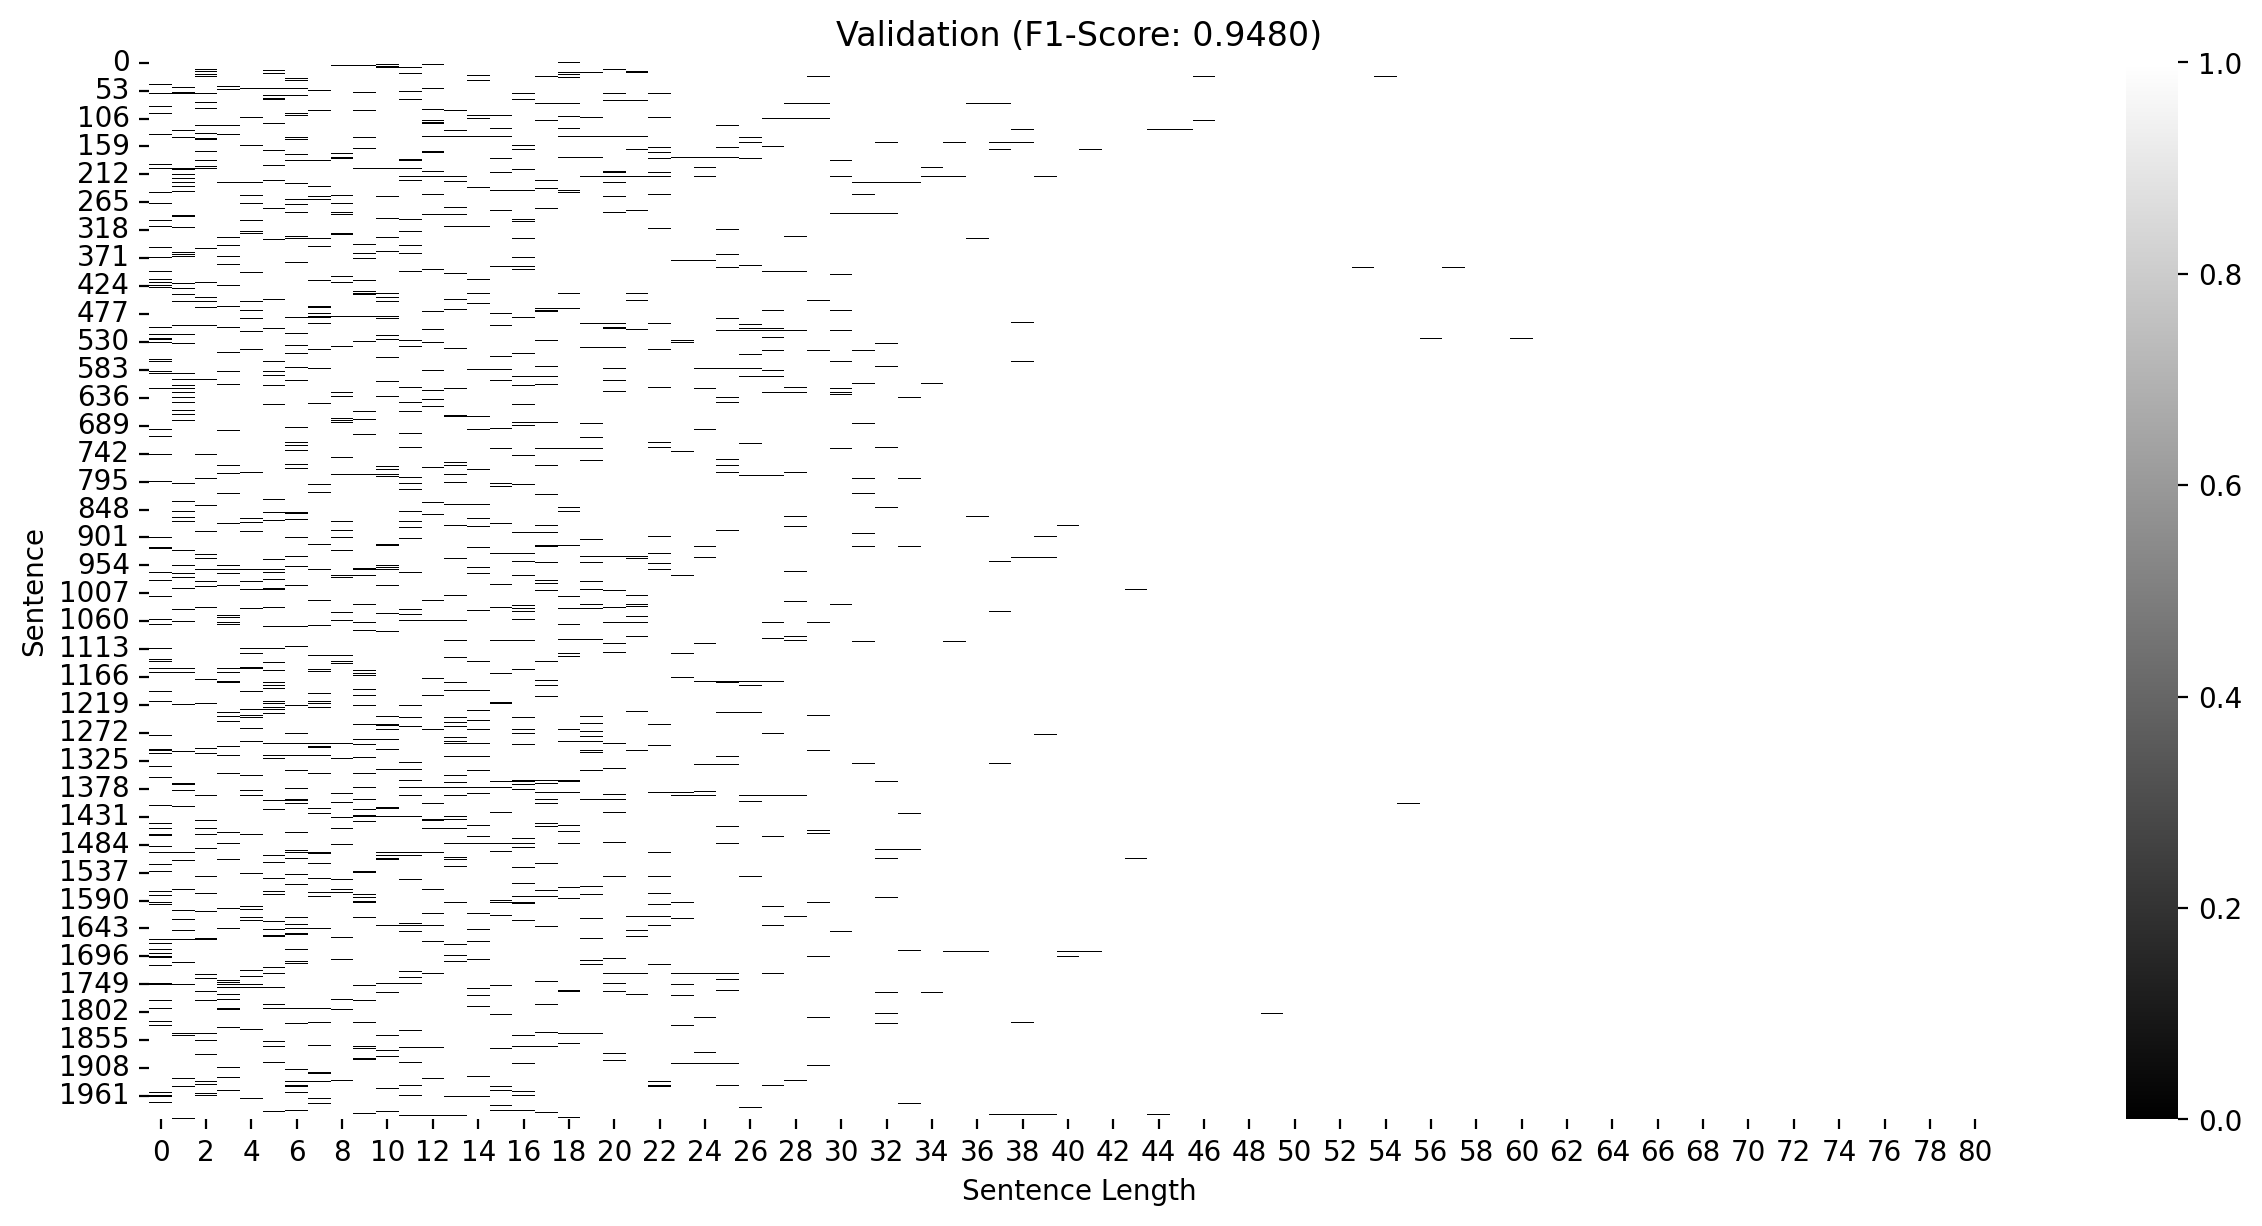

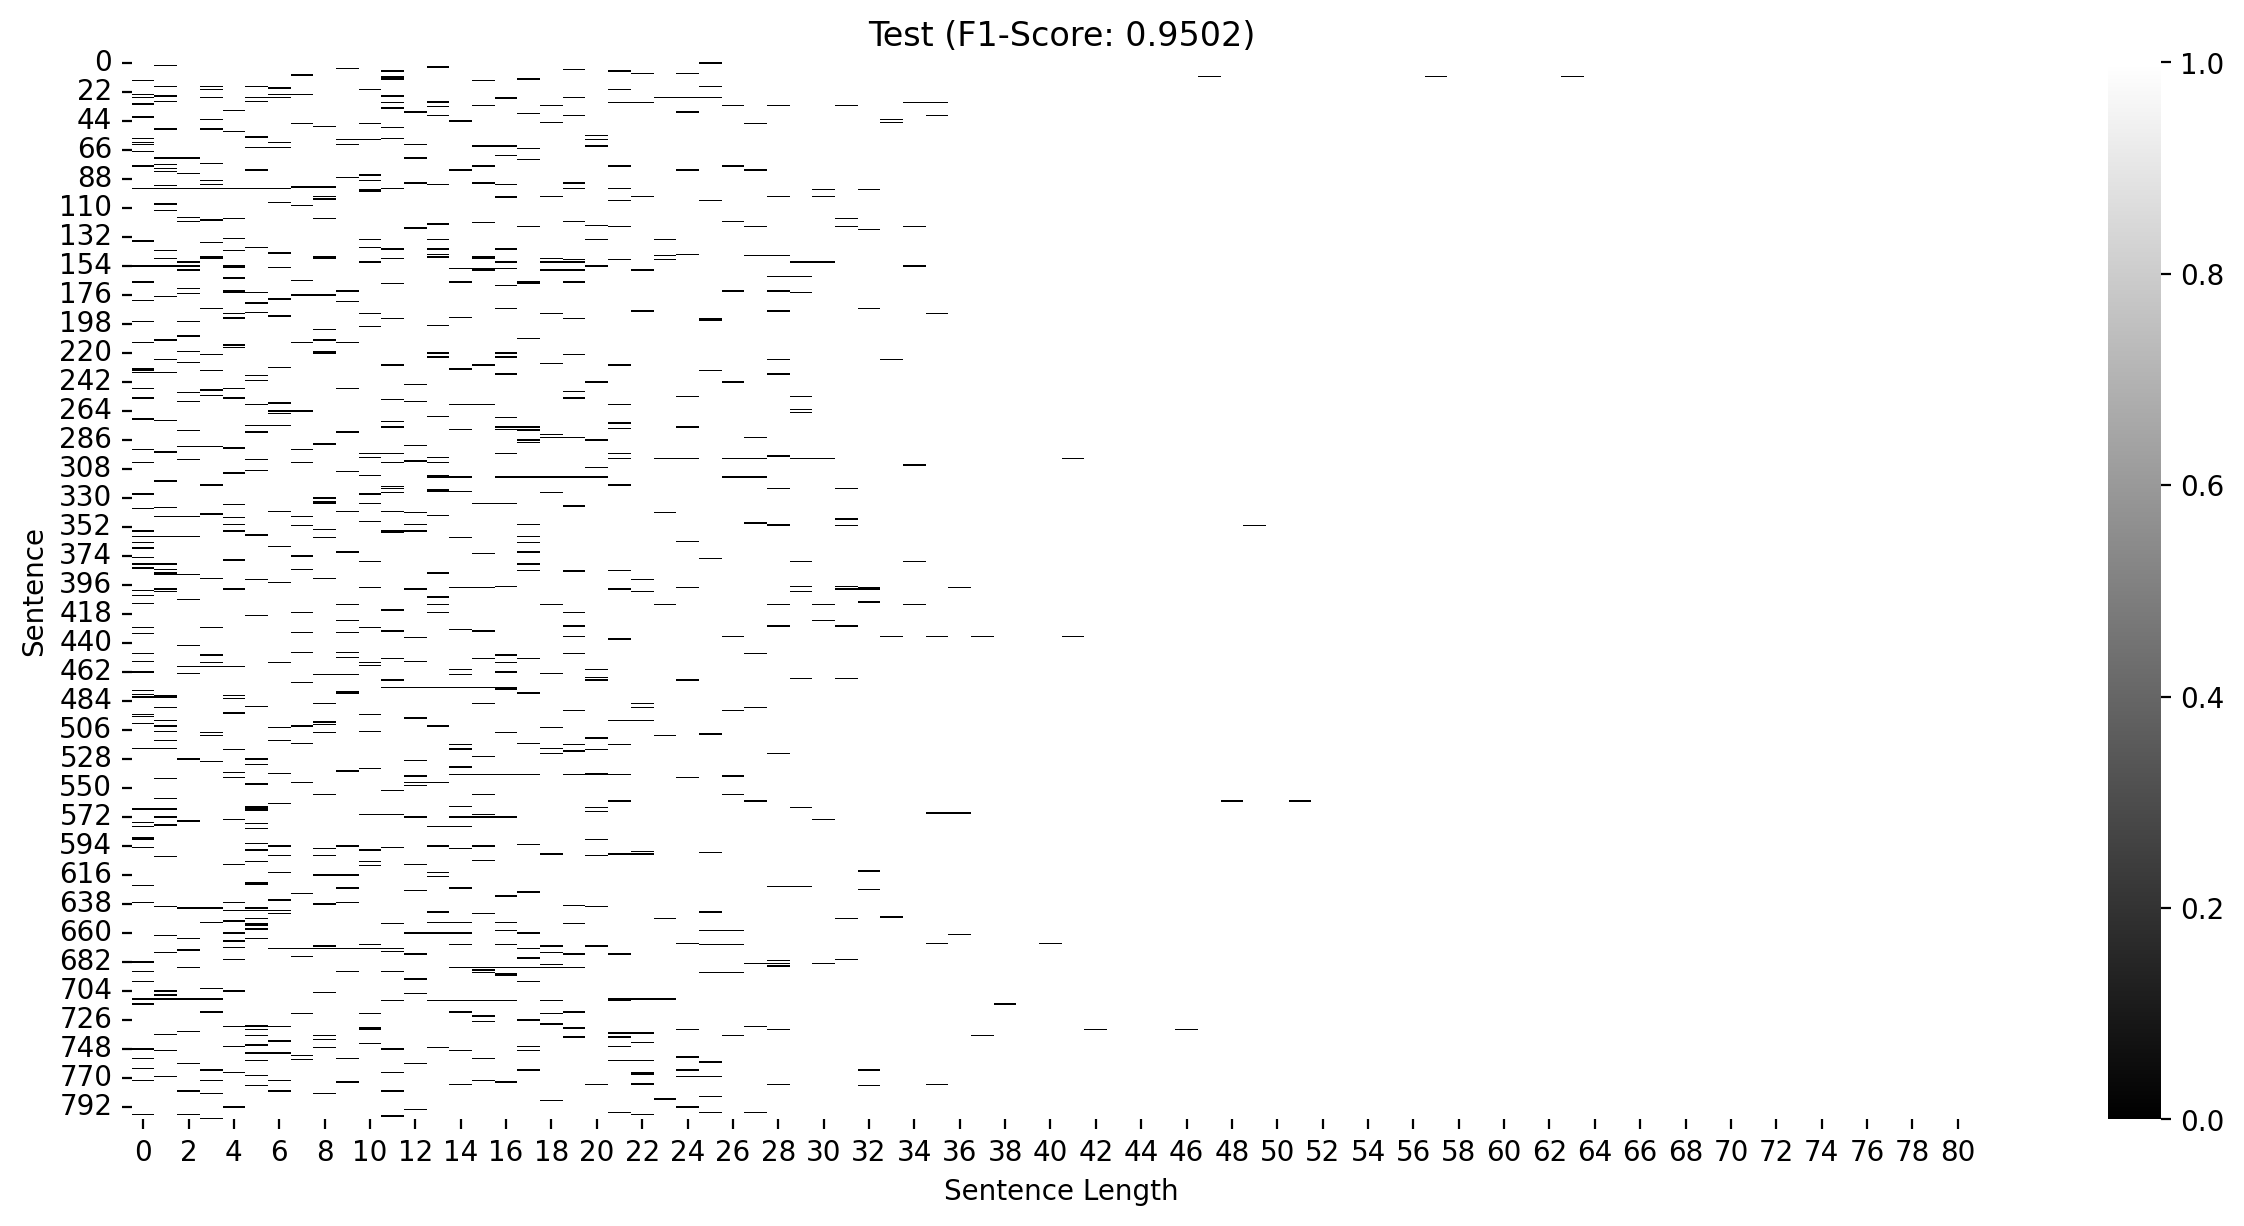

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


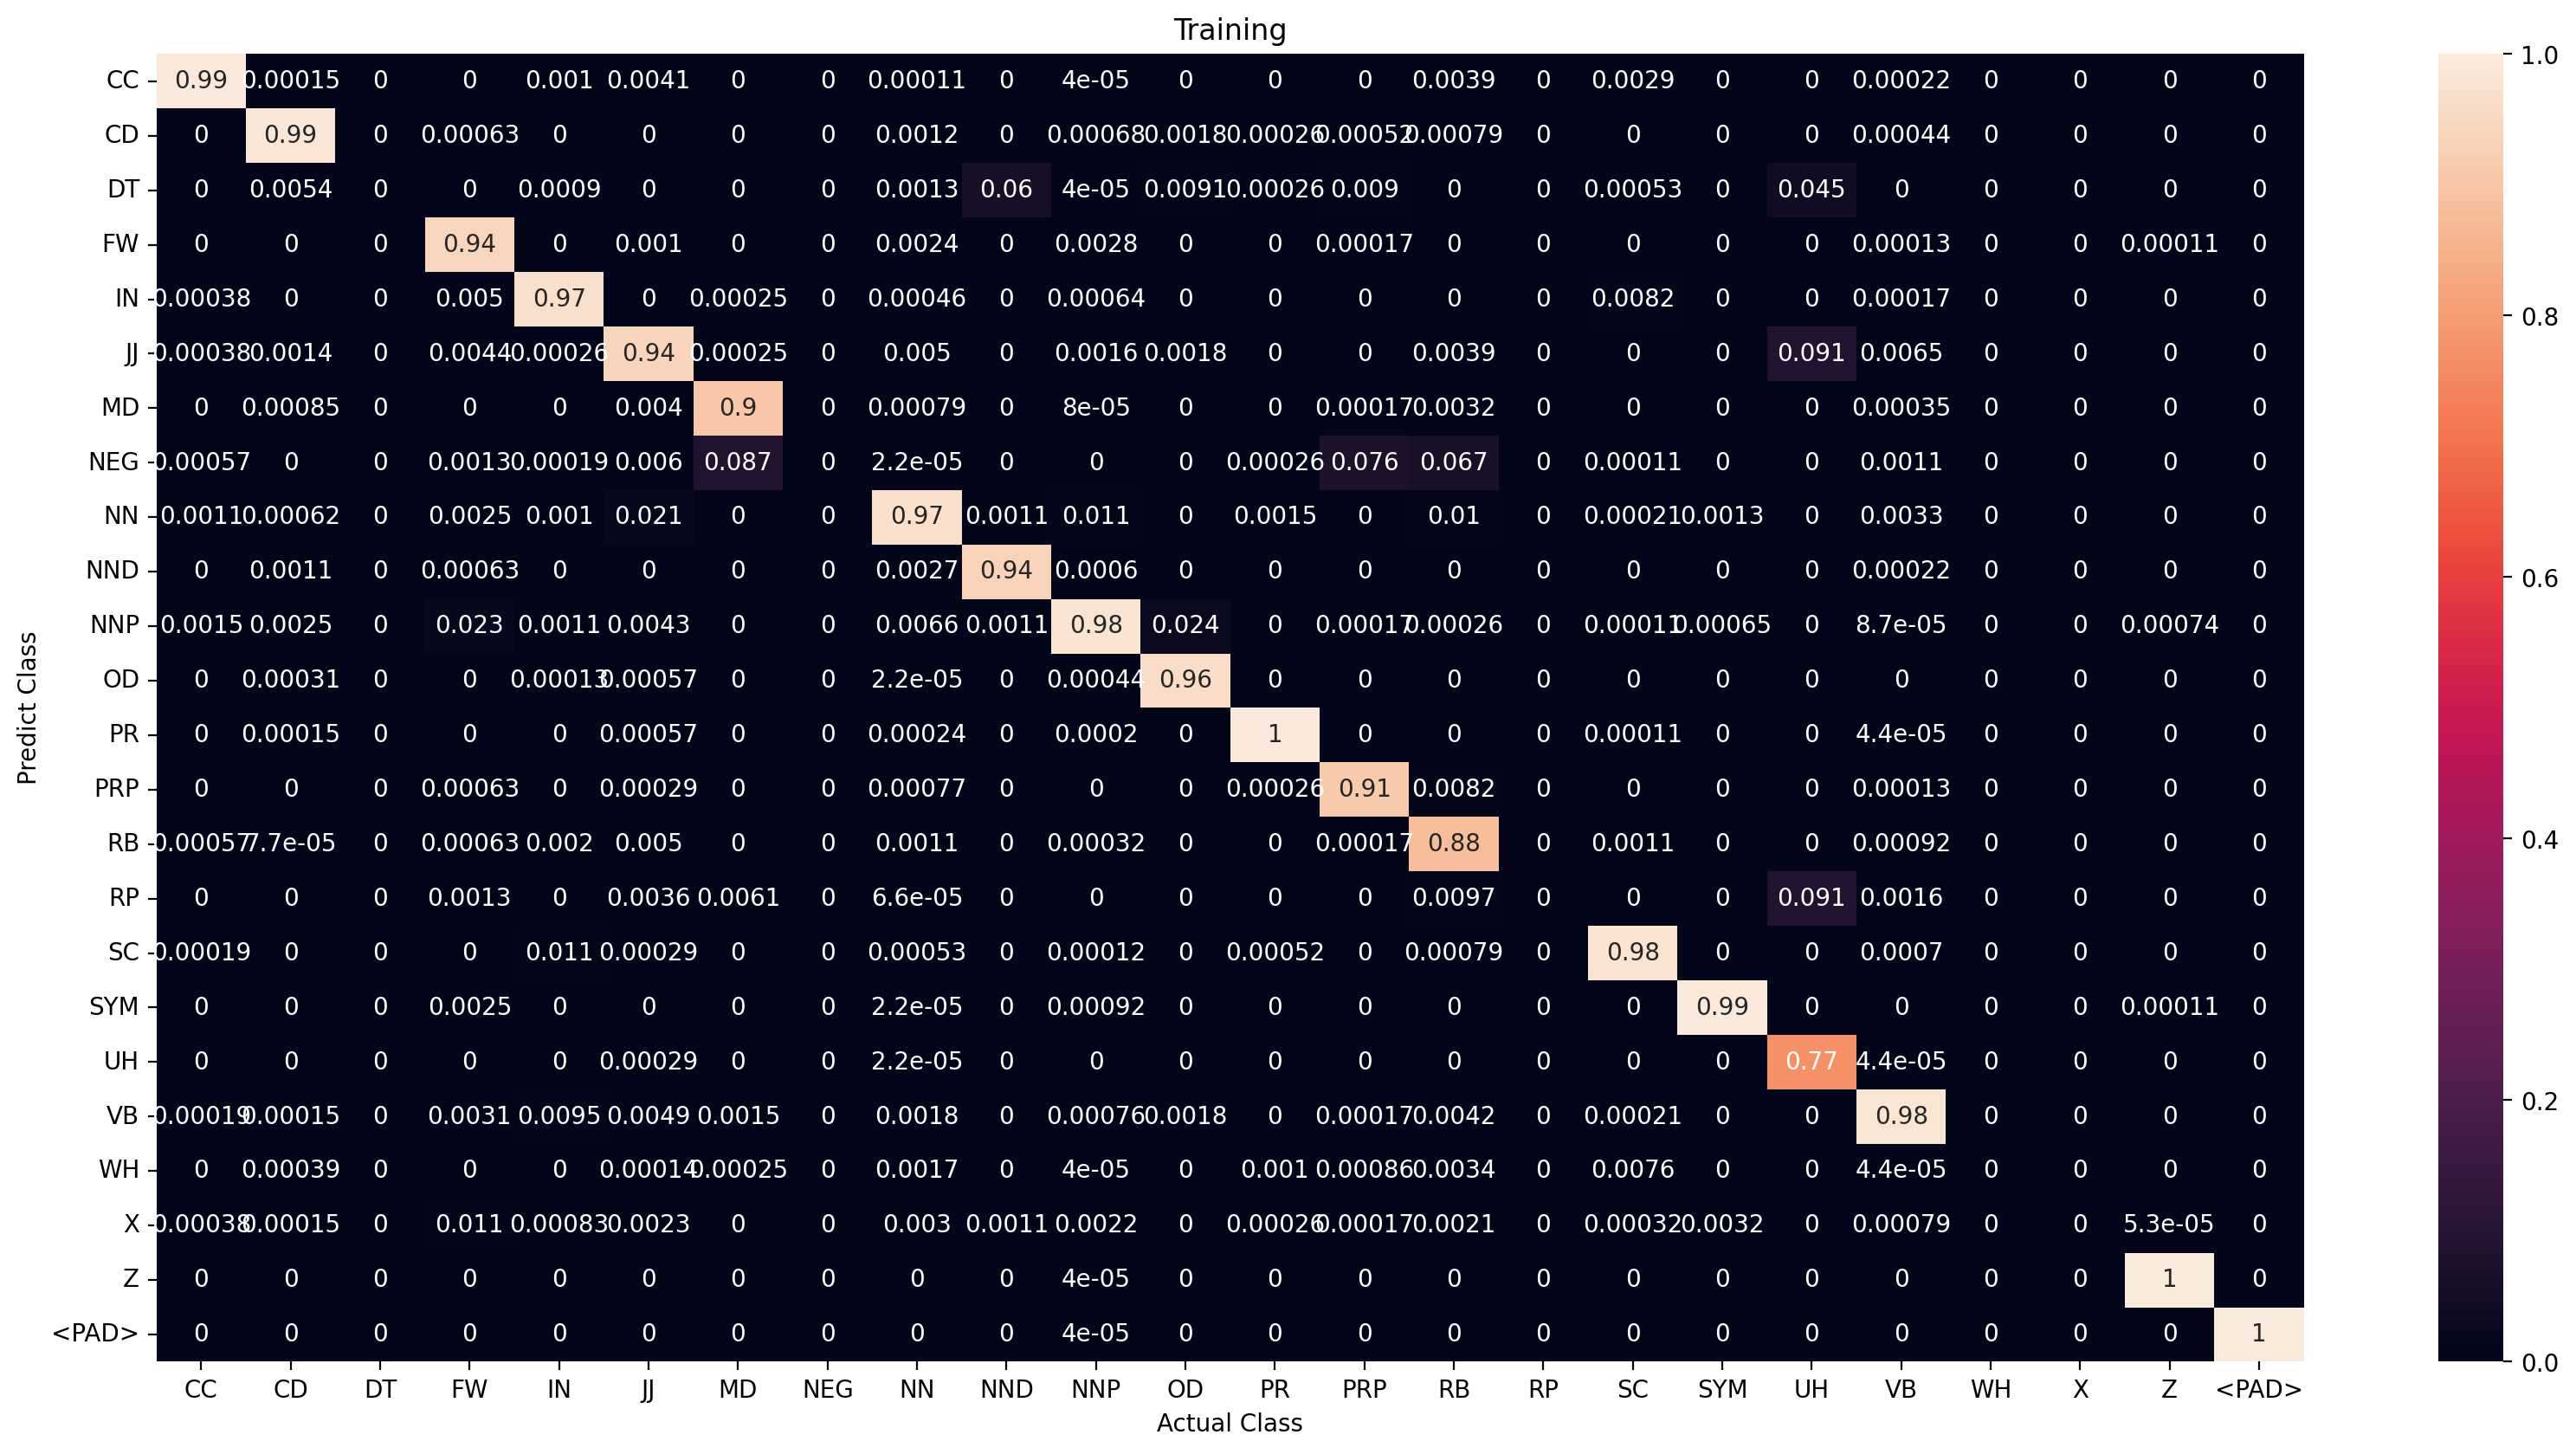

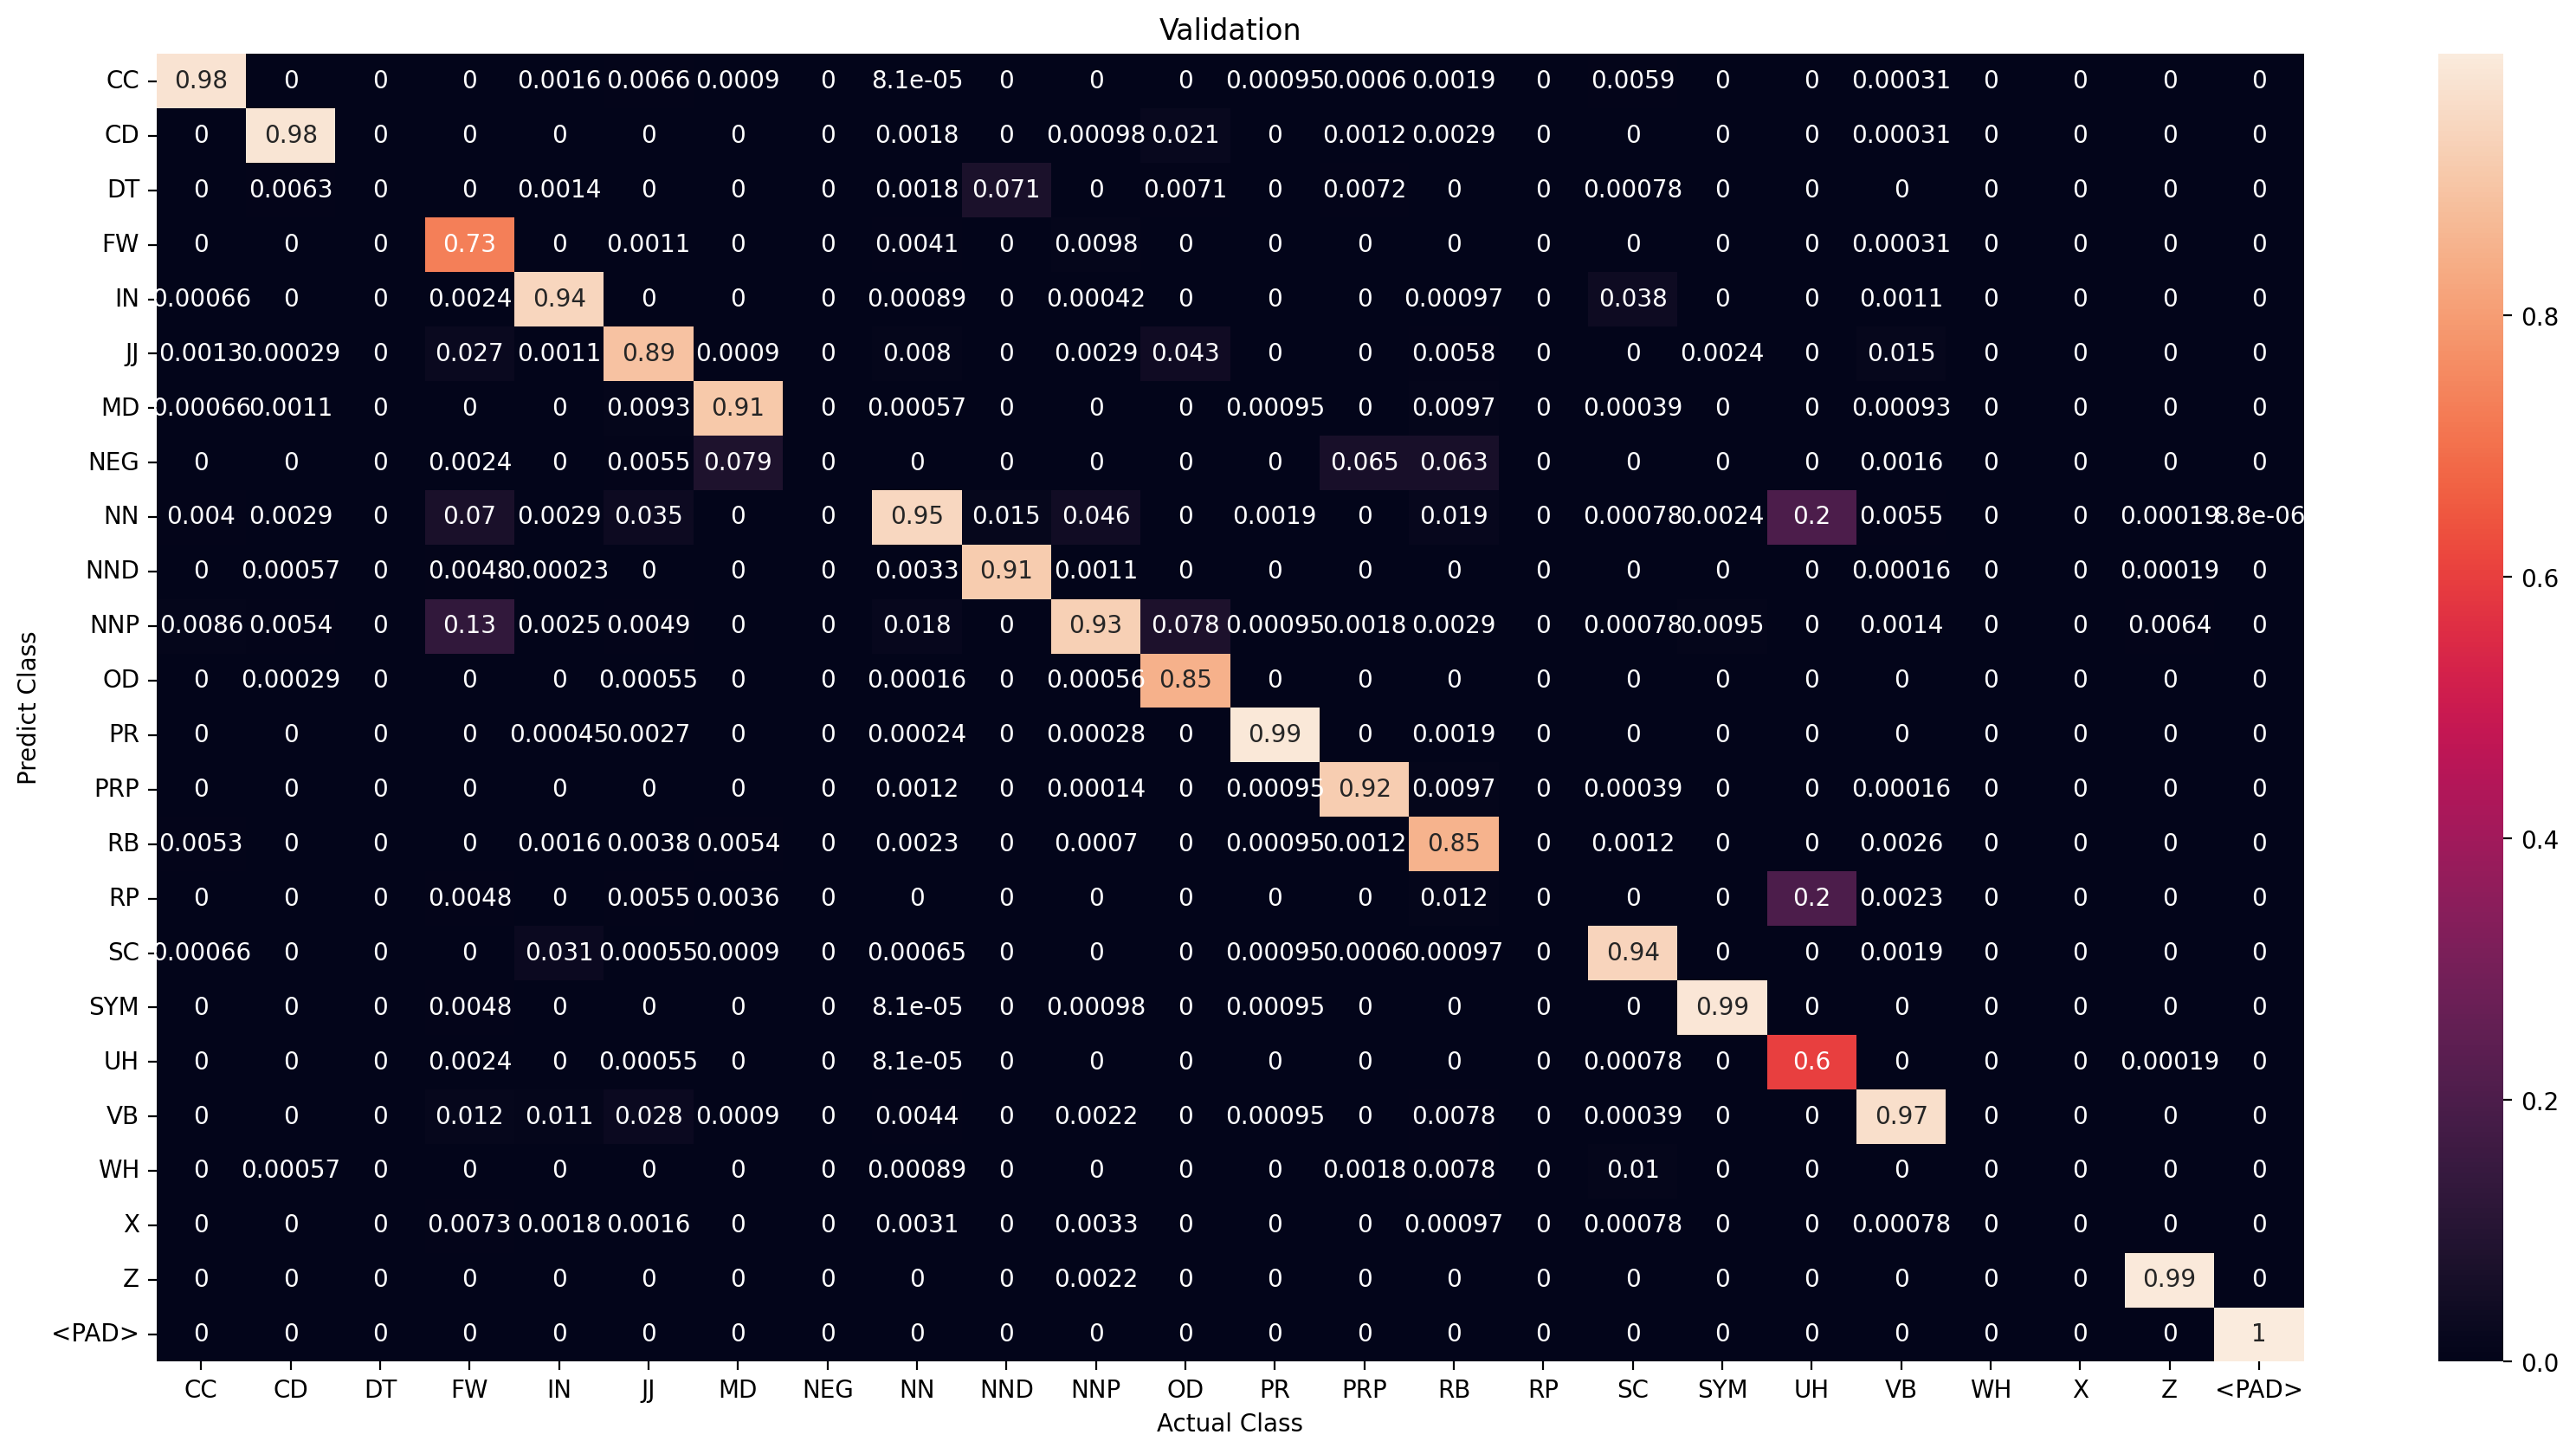

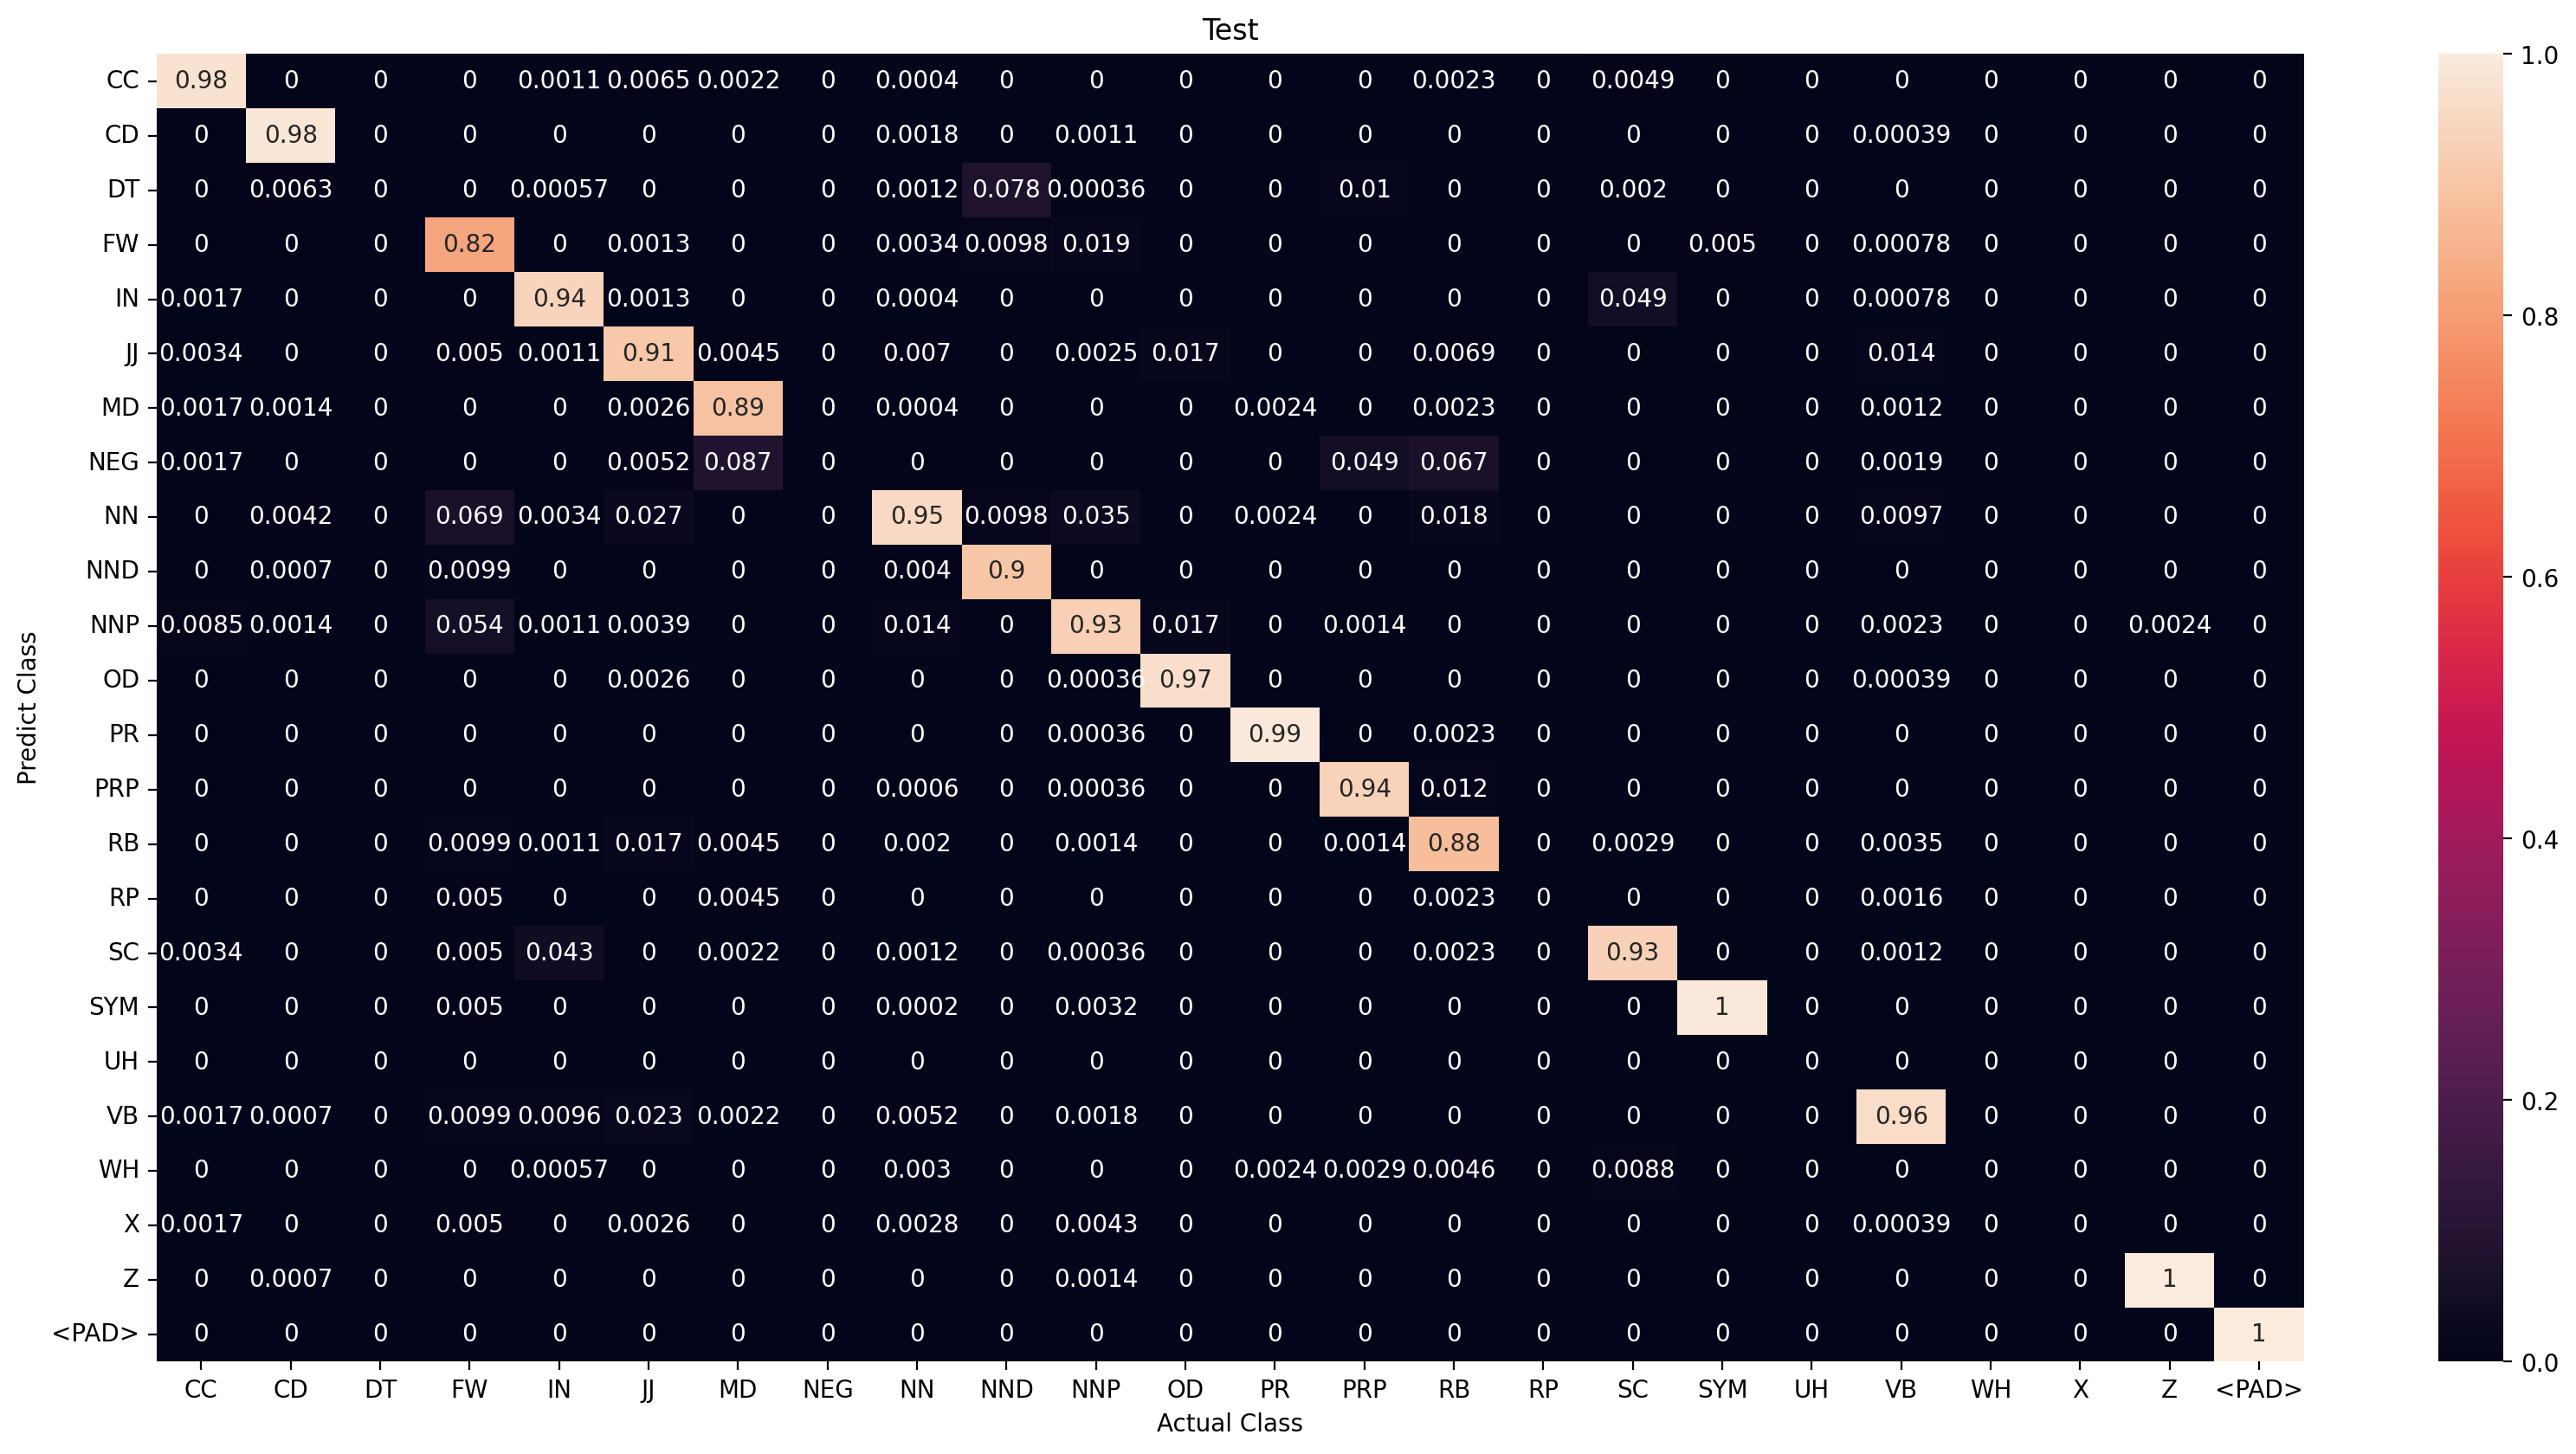

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5236       | CC    : 100      |
| CD    : 12904  | CD    : 12815      | CD    : 89       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1507       | FW    : 190      |
| IN    : 15290  | IN    : 15161      | IN    : 129      |
| JJ    : 7049   | JJ    : 6582       | JJ    : 467      |
| MD    : 3783   | MD    : 3685       | MD    : 98       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44182      | NN    : 587      |
| NND   : 998    | NND   : 842        | NND   : 156      |
| NNP   : 24884  | NNP   : 24427      | NNP   : 457      |
| OD    : 550    | OD    : 528        | OD    : 22       |
| PR    : 3878   | PR    : 3854       | PR    : 24       |
| PRP   : 5355   | PRP   : 5282       | PRP   : 73       |
| RB    : 3517   | RB    : 3355       | RB    : 162      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11271
Wrong prediction            : 663
Percentage correct oov pred : 94.44444444444444

Validation
Number OOV token            : 3261
Correct prediction          : 2923
Wrong prediction            : 338
Percentage correct oov pred : 89.63508126341613

Test
Number OOV token            : 1367
Correct prediction          : 1218
Wrong prediction            : 149
Percentage correct oov pred : 89.10021945866862



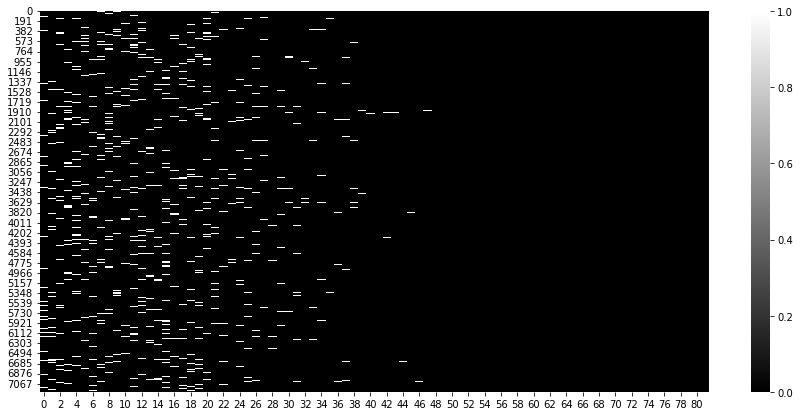

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

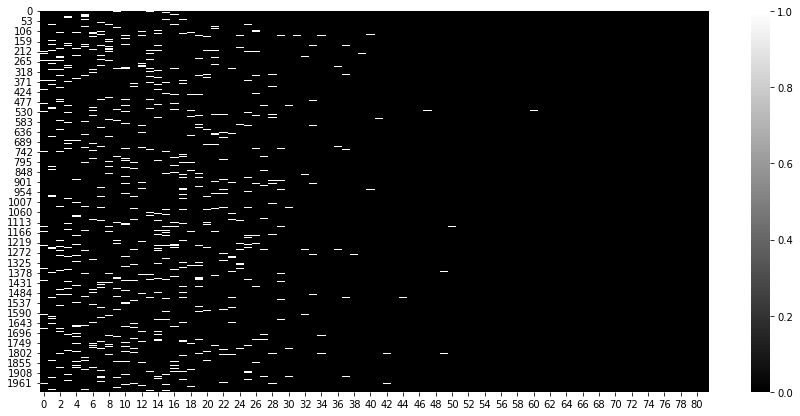

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

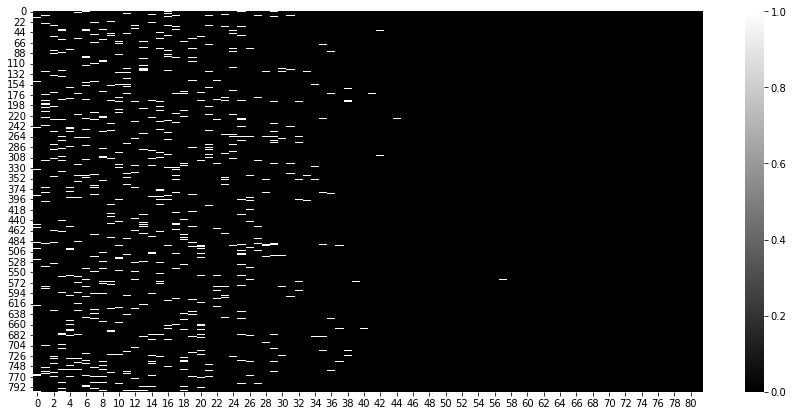

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);